<a href="https://colab.research.google.com/github/chandan2294/Time-Series-with-Deep-Learning-/blob/master/5_Deep_Neural_Network_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc3


In [0]:
def plot_series(time, series, format = '-', start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel('Value')
  plt.grid(True)

def trend(time, slope = 0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4, 
                  np.cos(season_time * 2 * np.pi), 
                  1/np.exp(3 * season_time))
  
def seasonality(time, period, amplitude = 1, phase = 0):
  season_time = ((time + phase) % period)/period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [0]:
time = np.arange(4 * 365 + 1, dtype = 'float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 20
slope = 0.09
noise_level = 5

#Create the series
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

#Update with noise
series += noise(time, noise_level, seed = 42)

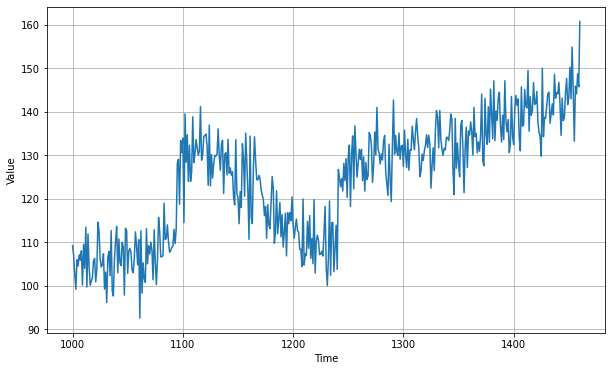

In [30]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

We learned how to break your data down into window chunks that you could train on, and then you saw a simple single layer neural network that gave a Linear Regression.

Now, let's take that into next step with DNN to see if we can improve our model accuracy. It's not that much different from the linear regression model we saw earlier. And this is relatively simple deep neural network that has three layers. 


In [33]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#Let's define the model
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1)
])

model.compile(loss = 'mse', optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs = 100, verbose = 0)

We defined the model with three layers of 10, 10, and 1 neurons. The input shape is the size of the window and we'll activate each layer using a relu.

We then compiled the model with a mean squared error loss function and stochastic gradient descent optimizer.

Finally, we'll fit the model over 100 epochs. To see the results, we implement the following code

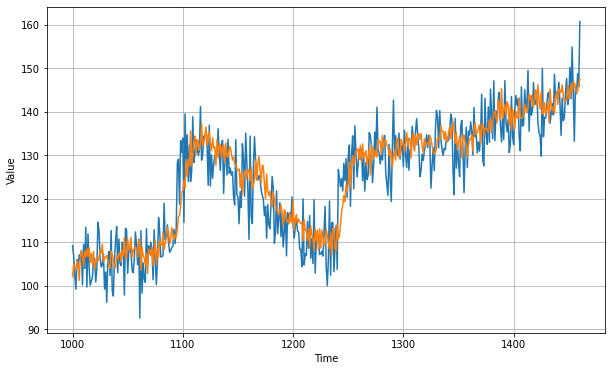

In [34]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [35]:
#Let's look at the Mean Absolute Error:

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.765275

Now, wouldn't it be nice if we could pick the optimal learning rate instead of the one that we chose? We might learn more efficiently and build a better model. Let's do that

The following code will be called at the callback at the end of each epoch. What it will do is change the learning rates to a value based on the epoch number. So in epoch 1, it is 1 x 10<sup>-8</sup> x 10<sup>1/20</sup>. And by the time we reach the 100 epoch, it'll be 1 x 10 <sup>-8</sup> x 10<sup>5</sup>, and that's 100/20. This will happen on each callback because we set it in the callbacks parameter of modeled outfit.




In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#Let's define the model
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1)
])

model.compile(loss = 'mse', optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs = 100, verbose = 0)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 **(epoch/20)
)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss = 'mse', optimizer=optimizer)
history = model.fit(dataset, epochs = 100, callbacks = [lr_schedule], verbose = 0)

After training with this, we can then plot the lost per epoch against the learning rate per epoch by using this code:

(1e-08, 0.001, 0.0, 300.0)

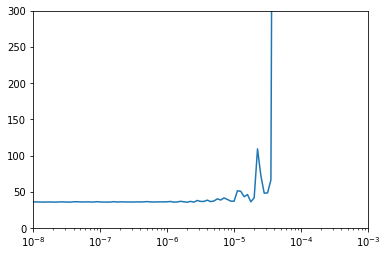

In [37]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [0]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

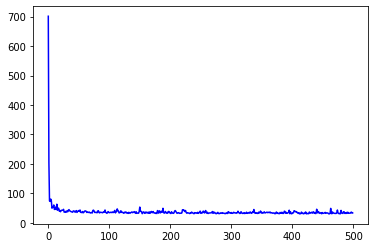

In [39]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[45.35353088378906, 48.029903411865234, 53.00570297241211, 45.20854187011719, 63.18006896972656, 42.85676193237305, 50.20671081542969, 49.347412109375, 39.80885314941406, 42.13146209716797, 37.765811920166016, 41.29750061035156, 42.87553787231445, 42.84965896606445, 42.49641418457031, 45.80204772949219, 36.19660949707031, 36.65851974487305, 35.93517303466797, 39.400794982910156, 36.60173034667969, 40.72783660888672, 37.73131561279297, 43.311336517333984, 44.793846130371094, 40.6548957824707, 39.937339782714844, 38.268375396728516, 37.536441802978516, 36.768043518066406, 36.03287124633789, 40.52606964111328, 39.84479904174805, 39.33171844482422, 35.690643310546875, 39.16285705566406, 41.59005355834961, 35.39570999145508, 38.64800262451172, 39.747535705566406, 41.62384796142578, 38.529170989990234, 43.46851348876953, 35.67406463623047, 35.291988372802734, 34.86530303955078, 38.415504455566406, 34.1773567199707, 34.84996032714844, 38.21179962158203, 40.3577880859375, 40.34162521362305, 39

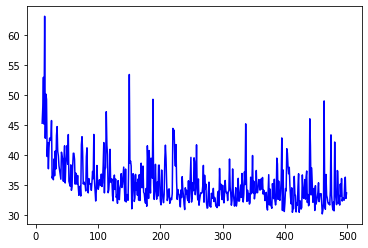

In [40]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

Concept:
We create an empty list of forecasts and then iterate over the series taking slices and window size, predicting them, and appending the results to the forecast list.

Explanation:

The forecast is a bunch of predictions over time. It is a list of predicted outputs, point by point, based on previous values.

Summary: 

Each iteration through model.predict() creates another predicted value that gets stored at the end of the forecast list. Finally, forecast will be a list of predictions for the time period, point by point.

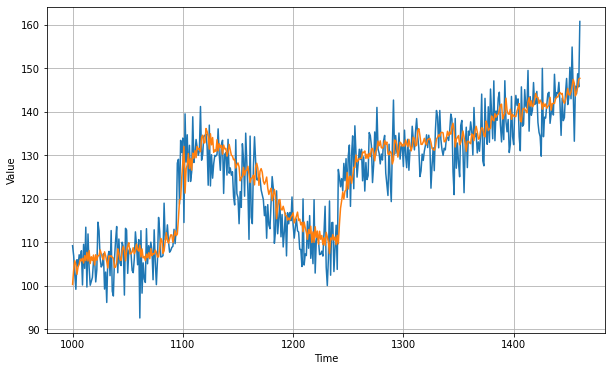

In [41]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [42]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.6460648